# Bioscrape Processes in Vivarium

This notebook shows how to create a [Bioscrape](https://github.com/biocircuits/bioscrape) Process in the [Vivarium](https://github.com/vivarium-collective) framework. Briefly, Bioscrape is a Chemical Reaction Network(CRN) Simulator that can simulate CRNs determinsitically, stochastically, stochastically with delay, and in single cells. This tutorial will show how to build a simple Bioscrape model programatically and load it into Vivarium. It will also cover using Bioscrape to load SBML models in Vivarium.

In [13]:
#Core imports
from bioscrape.types import Model #Used to create a Bioscrape Mode
from vivarium_bioscrape.processes.bioscrape import Bioscrape #used to wrap the bioscrape model in a vivarium process
from vivarium.core.composition import simulate_process


#For plotting and simulation purposes
import numpy as np
import pylab as plt

## Creating a simple CRN with the Bioscrape python API and Loading it into Vivarium:

We show how to programatically create a very simple CRN with two reactions modeling transcription of a gene $G$ to a transcript $T$ and translation of $T$ to a protein $P$. All species but $R$ and $G$ are degraded via dilution.

Transcription: $G \to G + T \quad \quad \rho_{tx}(G) = k_{tx} G$ is modeled using a massaction propensity.

Translation: $T \to T + P \quad \quad \rho_{tl}(T, R) = k_{tl}R \frac{T}{K + T}$ is modeled using a hill function involving the number of ribosomes $R$.

Degredation: $T \to \emptyset \quad\quad \rho_{dil}(T) = \delta T, \quad P \to \emptyset \quad\quad \rho_{dil}(P) = \delta P$ is modeled as a massaction propensity.

For more information on the Bioscrape API, including different reaction types, require parameters, etc. please see the [Bioscrape examples](https://github.com/biocircuits/bioscrape/tree/master/examples) or the [Bioscrape Wiki](https://github.com/biocircuits/bioscrape/wiki).

In [14]:
#Create a list of Species
species = ["G", "T", "P", "R"]

#Create a list of reactions
reactions = [
    (["G"], ["G", "T"], "massaction", {"k":"k_tx"}),
    (["T"], ["T", "P"], "proportionalhillpositive", {"k":"k_tl", "K":"K", "n":1, "s1":"G", "d":"R"}),
    (["T"], [], "massaction", {"k":"delta"}),
    (["P"], [], "massaction", {"k":"delta"}),
]

#Parameters
parameters = {"k_tx":.05, "k_tl":.1, "K":10, "delta":.001}

initial_condition = {"G":1.0, "R":100} #all other species default to 0

#Create a Bioscrape Model
M = Model(species = species, reactions = reactions, parameters = parameters, initial_condition_dict = initial_condition)

#Load the Bioscrape Model into a Bioscrape Vivarium Process. This requires setting a few internal parameters

parameters = {
    'bioscrape_model':M,
    'internal_dt':0.01, #default value is 0.01
    'stochastic': False, #default value is False
    'initial_volume':1.0 #default value is 1.0. Only relevant for stochastic models.
}

#Create a Bioscrape Process which can be integrated into a larger Vivarium Simulation
bioscrape_process = Bioscrape(parameters = parameters)


Simulation ID: a94df4b6-d153-11eb-8753-6c2b5976b3a5
Created: 06/19/2021 at 16:11:21
Completed in 0.298682 seconds


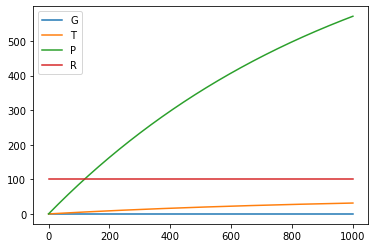

In [15]:
#Simulate the Bioscrape Process through Vivarium

#Set an initial condition
initial_state = bioscrape_process.initial_state() #get the initial state from the bioscrape object
#Alternatively you could make a dictionary {"species":{str(s):value} for s in species}

sim_settings = {
        'total_time': 1000,
        'initial_state': initial_state}

output = simulate_process(bioscrape_process, sim_settings)

#Plot the Output:
plt.figure()
for s in output["species"]:
    plt.plot(output["time"], output["species"][s], label = s)
plt.legend()

# Loading an SBML Model into Vivarium using Bioscrape

Bioscrape can read many Systems Biology Markup Langauge (SBML) Models. The Vivarium Bioscrape Process can similarly be used to load SBML into Vivarium. Note however that Bioscrape doesn't support all SBML features. Most CRN Models in a single compartment should be fine. Please see the Bioscrape documentation for details on features currently supported.

In [16]:
#Write an SBML Model Using Bioscrape, which will will the re-load
M.write_sbml_model("sbml_model.xml")

True

In [17]:
parameters = {
    'sbml_file': "sbml_model.xml",
    'internal_dt': 0.01, #default value is 0.01
    'stochastic': False, #default value is False
    'initial_volume':1.0 #default value is 1.0. Only relevant for stochastic models.
}

#create the Bioscrape Process which will automatically load an SBML file and create a bioscrape model
bvp = Bioscrape(parameters = parameters)


Simulation ID: af0e659e-d153-11eb-8eb8-6c2b5976b3a5
Created: 06/19/2021 at 16:11:31
Completed in 0.256406 seconds


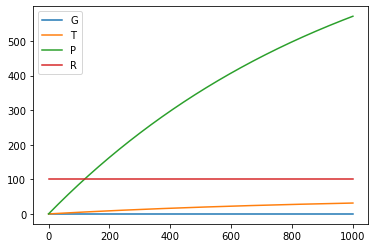

In [19]:
#simulate the Process
output = simulate_process(bioscrape_process, sim_settings)

#Plot the Output:
plt.figure()
for s in output["species"]:
    plt.plot(output["time"], output["species"][s], label = s)
plt.legend()